This network represents the neural connections of the Caenorhabditis elegans nematode (1986).   
D.J. Watts and S.H. Strogatz, "Collective dynamics of 'small-world' networks." Nature 393, 440-442 (1998).

Each node is a neuron.

Each edge is a synaptic link.


In [1]:
# import libraries
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt, animation
from networkx.drawing.nx_pydot import graphviz_layout
import copy
import time
import random
import itertools
from itertools import islice

%matplotlib notebook

# Load graph using NetworkX
def load_graph_from_file(file):
    G = nx.read_gml(file)
    return G
# G = nx.complete_graph(4)

In [2]:
# Visualize network
def visualize_as_shell(graph, figure_name, figure_size):
    plt.figure(figure_name,figsize=figure_size)
    pos = nx.shell_layout(G, center=(1,1)) # other layouts: bipartite, circular*, kamada_kawai, planar, random, rescale, shell*, spring, spectral, spiral
    
    groups = set([d[1] for d in G.degree()])
    mapping = dict(zip(sorted(groups),count()))
    colors = [mapping[d[1]] for d in G.degree()]
    
#     nx.draw(G, pos, node_size=250, arrows=graph.is_directed()) #, node_colors=colors)
    nx.draw(G, with_labels=False, node_size=200, pos=pos, node_color=colors, arrows=graph.is_directed())
    nx.draw_networkx_labels(G, pos, font_size=10)

In [3]:
# Could visualize with colored nodes for higher degree
from itertools import count
def visualize_with_colors_for_degree(graph, figure_name, figure_size):
    plt.figure(figure_name,figsize=figure_size)

    groups = set([d[1] for d in G.degree()])
    mapping = dict(zip(sorted(groups),count()))
    colors = [mapping[d[1]] for d in G.degree()]

    nx.draw(G, with_labels=False, node_size=200, pos=nx.fruchterman_reingold_layout(G), node_color=colors, arrows=graph.is_directed())

In [4]:
def describe_network(graph):

    # Describe the network: 
    # Get Node info
    G = graph
    nodelist = G.nodes

    # Get Edge info
    edgearray = G.edges.data()
    edges_without_weight = []
    duplicates = []
    duplicate_edges = []
    for edge in edgearray:
        if (edge[0], edge[1]) in edges_without_weight:
            duplicates.append((edge[0], edge[1]))
        edges_without_weight.append((edge[0], edge[1]))

    print('There are {} duplicate edges: {}'.format(len(duplicates), duplicates))

    for edge in edgearray:
        if (edge[0], edge[1]) in duplicates:
            duplicate_edges.append(edge)

    print('These duplicates result in a total of {} edges: {}'.format(len(duplicate_edges), duplicate_edges))

    # What is the average degree? Get degree info
    degrees = G.degree()
    if G.is_directed():
        indegrees = G.in_degree()
        outdegrees = G.out_degree()
        averageindegree = (sum([val for (node, val) in sorted(indegrees, key=lambda pair: pair[0])])) / len(nodelist)
        averageoutdegree = (sum([val for (node, val) in sorted(outdegrees, key=lambda pair: pair[0])])) / len(nodelist)
    else:
        averageindegree = "There are no indegrees for undirected graph"
        averageoutdegree = "There are no outdegrees for undirected graph"

    averagedegree = (sum([val for (node, val) in sorted(degrees, key=lambda pair: pair[0])])) / len(nodelist)
    density = (len(edgearray))/((len(nodelist))*(len(nodelist)-1))
    if not G.is_multigraph() and not G.is_directed():
        avg_clustering_coeff = nx.average_clustering(G)
        betweenness_centrality = nx.betweenness_centrality(G)
    else:
        avg_clustering_coeff = "Is not defined for a multigraph or digraph"
        betweenness_centrality = "Is not defined for a multigraph or digraph"
        
    print('avarage degree: {}'.format(averagedegree))
    print('average indegree: {}'.format(averageindegree))
    print('average outdegree: {}'.format(averageoutdegree))
    print('density (can be above 1 for multigraphs): {}'.format(density))
    print('average clustering coefficient: {}'.format(avg_clustering_coeff))
    print('betweenness centrality: {}'.format(betweenness_centrality))


    return averagedegree, averageindegree, averageoutdegree, density, avg_clustering_coeff, betweenness_centrality
    # What are some other static network measures, and 
    # why are they significant to this system? Get other info 

We can convert the MultiDiGraph to a simple DiGraph by adding the weights on the duplicated edges. There are only 14 of these, so we perform this step below.

In [5]:
# Converting multigraph to simple graph
def convert_multigraph_to_simple(graph):
    G = graph
    G2 = nx.DiGraph()
    duplicate_edges = []
    duplicates = []
    for u,v,data in G.edges(data=True):
        w = data['value']
        if G2.has_edge(u,v):
            G2[u][v]['weight'] += w
            if (u,v) not in duplicates:
                duplicates.append((u,v))
            duplicate_edges.append((u,v,data))
            duplicate_edges.append((u,v,{'value': G2[u][v]['weight']-w}))
        else:
            G2.add_edge(u, v, weight=w)

    # print(G.edges(data=True))
    print('duplicates found (should match above): {}'.format(duplicates))
    print('duplicate edges found (should match above): {} '.format(duplicate_edges))
    print(len(G2.edges.data()))
    return G2

In [6]:
# Are there any nodes that don't have any edges going into them?
# Are there any nodes that don't have any edges going out of them
def find_disconnected_nodes(graph):
    G = graph
    nodelist = G.nodes
    edgearray = G.edges.data()
    nodes_have_incoming_edge_list = []
    nodes_have_outgoing_edge_list = []
    for node in nodelist:
        node_has_incoming_edge = False
        node_has_outgoing_edge = False
        for edge in edgearray:
            if edge[1] == node:
                node_has_incoming_edge = True
            if edge[0] == node:
                node_has_outgoing_edge = True
        nodes_have_incoming_edge_list.append((node, node_has_incoming_edge))
        nodes_have_outgoing_edge_list.append((node, node_has_outgoing_edge))

    print("nodes_without_incoming edges: {}".format([x[0] for x in nodes_have_incoming_edge_list if x[1]==False]))
    print("nodes_without_outgoing_edges: {}".format([x[0] for x in nodes_have_outgoing_edge_list if x[1]==False]))
    return [x[0] for x in nodes_have_incoming_edge_list if x[1]==False], [x[0] for x in nodes_have_outgoing_edge_list if x[1]==False]

    # There are. This causes the voter model to fail, so we will need to convert the graph to undirected:

In [7]:
def draw_voter_model(i):
    fig.clear()
    iteration = model.iteration()
    
    pos = nx.shell_layout(g)  # positions for all nodes

    # get nodes that vote 0:
    nodes_0 = []
    nodes_1 = []
    for node, status in model.status.items():
        if status == 0:
            nodes_0.append(node)
        else:
            nodes_1.append(node)


    # nodes
    options = {"edgecolors": "tab:gray", "node_size": 250}
    nx.draw_networkx_nodes(g, pos, nodelist=nodes_0, node_color="tab:red", **options)
    nx.draw_networkx_nodes(g, pos, nodelist=nodes_1, node_color="tab:blue", **options)

    # edges
    nx.draw_networkx_edges(g, pos, alpha=0.5)
    nx.draw_networkx_edges(g,pos)

    # labels
    nx.draw_networkx_labels(g, pos, font_size=10, font_color="whitesmoke")
    
    fig.suptitle("Frame %d:    "%(i+1), fontweight="bold")
#     ax.set_xticks([])
#     ax.set_yticks([])

In [8]:
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op

class voterModel:
    
    def __init__(self, graph, config):
        self.model = op.VoterModel(graph)
        self.config = config
        self.model.set_initial_status(config)


        
def create_voter_model(graph, fraction):
    config = mc.Configuration()
    config.add_model_parameter('fraction_infected', fraction)
    return voterModel(graph, config).model

def calculate_voter_convergence(model):
    num_iters = 0
    unchanged = 0
    prev_model_status = None
    status_over_time = []
    status_count_over_time = []

#     while unchanged < 1000:
    while (len(status_count_over_time) == 0 or 
        (status_count_over_time[-1] != len(model.status) and status_count_over_time[-1] != 0 and
        unchanged < 1000)):
        num_iters += 1
        if len(status_over_time) > 0 and model.status == status_over_time[-1]:
            unchanged += 1
        else:
            unchanged = 0
        status_over_time.append(copy.deepcopy(model.status))
        status_count_over_time.append(model.status_delta(model.status)[1][1])
        iteration = model.iteration()
        
    if unchanged >= 1000:
        return num_iters-1000, status_count_over_time
    
    return num_iters, status_count_over_time

In [9]:
import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats

def plot_mean_and_bootstrapped_ci_multiple(input_data = None, title = 'overall', name = "change this", x_label = "x", y_label = "y", save_name=""):
    """ 
     
    parameters:  
    input_data: (numpy array of numpy arrays of shape (max_k, num_repitions)) solution met
    name: numpy array of string names for legend 
    x_label: (string) x axis label 
    y_label: (string) y axis label 
     
    returns: 
    None 
    """ 
 
    generations = len(input_data[0])
 
    fig, ax = plt.subplots() 
    ax.set_xlabel(x_label) 
    ax.set_ylabel(y_label) 
    ax.set_title(title) 
    for i in range(len(input_data)): 
        CIs = [] 
        mean_values = [] 
        for j in range(generations): 
            mean_values.append(np.mean(input_data[i][j])) 
#             CIs.append(bootstrap.ci(input_data[i][j], statfunction=np.mean)) 
        mean_values=np.array(mean_values) 
 
#         print(CIs) 
#         high = [] 
#         low = [] 
#         for j in range(len(CIs)): 
#             low.append(CIs[j][0]) 
#             high.append(CIs[j][1]) 
 
#         low = np.array(low) 
#         high = np.array(high) 

        y = range(0, generations) 
        ax.plot(y, mean_values, label=name[i]) 
#         ax.fill_between(y, high, low, alpha=.2) 
        ax.legend()

In [10]:
G = load_graph_from_file("celegansneural/celegansneural.gml")

<IPython.core.display.Javascript object>


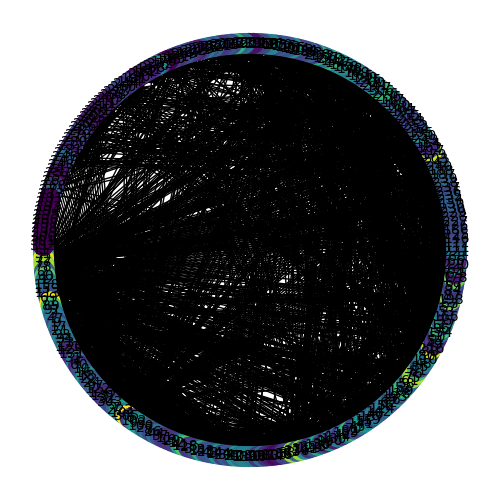

<IPython.core.display.Javascript object>


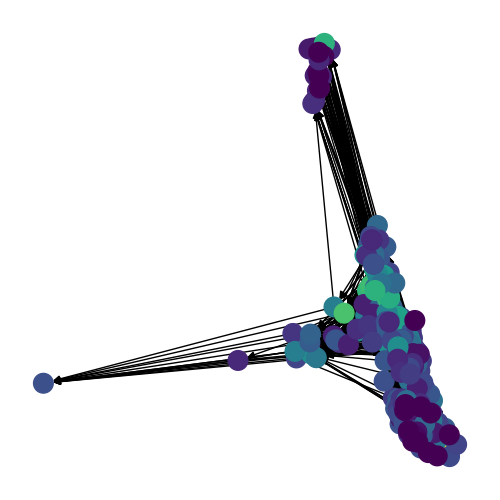

In [11]:
visualize_as_shell(G, '1', (5,5))
visualize_with_colors_for_degree(G, '2', (5,5))

In [12]:
describe_network(G)

There are 14 duplicate edges: [('71', '240'), ('39', '303'), ('141', '23'), ('178', '305'), ('111', '303'), ('177', '305'), ('199', '189'), ('172', '150'), ('149', '187'), ('149', '250'), ('149', '306'), ('269', '305'), ('268', '305'), ('273', '305')]
These duplicates result in a total of 28 edges: [('71', '240', {'value': 1}), ('71', '240', {'value': 2}), ('39', '303', {'value': 1}), ('39', '303', {'value': 2}), ('141', '23', {'value': 1}), ('141', '23', {'value': 1}), ('178', '305', {'value': 3}), ('178', '305', {'value': 21}), ('111', '303', {'value': 1}), ('111', '303', {'value': 1}), ('177', '305', {'value': 3}), ('177', '305', {'value': 22}), ('199', '189', {'value': 1}), ('199', '189', {'value': 3}), ('172', '150', {'value': 1}), ('172', '150', {'value': 1}), ('149', '187', {'value': 1}), ('149', '187', {'value': 1}), ('149', '250', {'value': 1}), ('149', '250', {'value': 1}), ('149', '306', {'value': 1}), ('149', '306', {'value': 1}), ('269', '305', {'value': 2}), ('269', '305'

(15.885521885521886,
 7.942760942760943,
 7.942760942760943,
 0.026833651833651835,
 'Is not defined for a multigraph or digraph',
 'Is not defined for a multigraph or digraph')

duplicates found (should match above): [('71', '240'), ('39', '303'), ('141', '23'), ('178', '305'), ('111', '303'), ('177', '305'), ('199', '189'), ('172', '150'), ('149', '187'), ('149', '250'), ('149', '306'), ('269', '305'), ('268', '305'), ('273', '305')]
duplicate edges found (should match above): [('71', '240', {'value': 2}), ('71', '240', {'value': 1}), ('39', '303', {'value': 2}), ('39', '303', {'value': 1}), ('141', '23', {'value': 1}), ('141', '23', {'value': 1}), ('178', '305', {'value': 21}), ('178', '305', {'value': 3}), ('111', '303', {'value': 1}), ('111', '303', {'value': 1}), ('177', '305', {'value': 22}), ('177', '305', {'value': 3}), ('199', '189', {'value': 3}), ('199', '189', {'value': 1}), ('172', '150', {'value': 1}), ('172', '150', {'value': 1}), ('149', '187', {'value': 1}), ('149', '187', {'value': 1}), ('149', '250', {'value': 1}), ('149', '250', {'value': 1}), ('149', '306', {'value': 1}), ('149', '306', {'value': 1}), ('269', '305', {'value': 8}), ('269', 

<IPython.core.display.Javascript object>


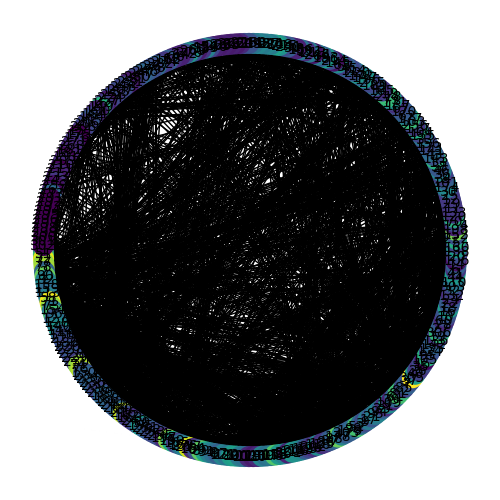

<IPython.core.display.Javascript object>


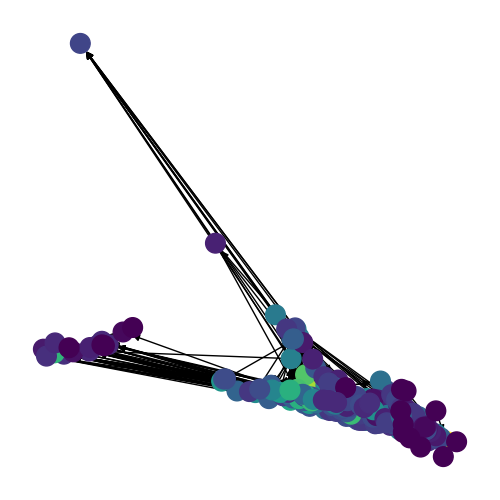

There are 0 duplicate edges: []
These duplicates result in a total of 0 edges: []
avarage degree: 15.79124579124579
average indegree: 7.895622895622895
average outdegree: 7.895622895622895
density (can be above 1 for multigraphs): 0.026674401674401674
average clustering coefficient: Is not defined for a multigraph or digraph
betweenness centrality: Is not defined for a multigraph or digraph


(15.79124579124579,
 7.895622895622895,
 7.895622895622895,
 0.026674401674401674,
 'Is not defined for a multigraph or digraph',
 'Is not defined for a multigraph or digraph')

In [13]:
G = convert_multigraph_to_simple(G)
visualize_as_shell(G, '3', (5,5))
visualize_with_colors_for_degree(G, '4', (5,5))
describe_network(G)

In [14]:
no_incoming_edge, no_outgoing_edge = find_disconnected_nodes(G)
completely_disconnected = []
if len(no_incoming_edge) > 0 and len(no_outgoing_edge) > 0:
    for node in no_incoming_edge:
        if node in no_outgoing_edge:
            completely_disconnected.append(node)
print("There are a total of {} nodes that are completely disconnected".format(len(completely_disconnected)))
print("\nIt may benefit us to convert this graph to undirected to perform the voter model \n" +
    "experiment since the model we use here will struggle if the node has no incoming edges.")

nodes_without_incoming edges: ['11', '12', '53', '64', '151', '175', '176', '191', '210', '211', '212', '243', '259', '267', '273', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302']
nodes_without_outgoing_edges: ['305', '306', '303']
There are a total of 0 nodes that are completely disconnected

It may benefit us to convert this graph to undirected to perform the voter model 
experiment since the model we use here will struggle if the node has no incoming edges.


In [24]:
g = G.to_undirected()
ad, aid, aod, den, acc, bc = describe_network(g)

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print(dict(sorted(bc.items(), key=lambda item: item[1])))
top_10 = take(10, dict(sorted(bc.items(), key=lambda item: item[1])).items())
bottom_10 = take(10, dict(sorted(bc.items(), key=lambda item: item[1], reverse=True)).items())
print(top_10)
print(bottom_10)

There are 0 duplicate edges: []
These duplicates result in a total of 0 edges: []
avarage degree: 14.464646464646465
average indegree: There are no indegrees for undirected graph
average outdegree: There are no outdegrees for undirected graph
density (can be above 1 for multigraphs): 0.024433524433524433
average clustering coefficient: 0.2923632978321903
betweenness centrality: {'1': 0.001213353962106609, '51': 0.01574263220410914, '72': 0.04801549330577608, '77': 0.028535608144431866, '78': 0.031163449440266954, '2': 0.0030458921848214096, '90': 0.018474870705423054, '92': 0.004705215633435171, '158': 0.004090854671225415, '159': 0.0027840039170696643, '113': 0.004833755630940964, '58': 0.004668422846071324, '71': 0.05759006668189357, '73': 0.0245029035321954, '154': 0.0007345842863693228, '96': 0.00976574450109922, '127': 0.003180632172648924, '128': 0.0046953203212667, '140': 0.005783679167607876, '144': 0.004861382220990804, '146': 0.0016177231233559023, '225': 0.001758603293018984

In [193]:
# Make animation of voter model
# model = create_voter_model(g, 0.4)

# fig = plt.figure(figsize=(50,50))
# n_iter = 2000
# ani = animation.FuncAnimation(fig, draw_voter_model, frames=n_iter, interval=100, repeat=False)

# ani.save('dynamic_images.mp4')

In [194]:
# Create and run voter model
num_runs = 10
num_iters_list = []
status_count_over_time_list = np.zeros((num_runs, 200000))
fraction_infected = 0.6

for i in range(num_runs):
    start_time = time.time()
    model = create_voter_model(g, fraction_infected)
    num_iters, status_count_over_time = calculate_voter_convergence(model)
    status_count_over_time = np.array([status_count_over_time[j] if j < len(status_count_over_time) else status_count_over_time[-1] for j in range(status_count_over_time_list.shape[1])])
    num_iters_list.append(num_iters)
    status_count_over_time_list[i] = status_count_over_time
    print('convergence of voter model', i, time.time()-start_time, num_iters)

status_count_over_time_list_truncated = np.zeros((num_runs, max(num_iters_list)))
for i in range(num_runs):
    status_count_over_time_list_truncated[i] = status_count_over_time_list[i][:max(num_iters_list)]
status_count_over_time_list = np.zeros((num_runs, max(num_iters_list)))
status_count_over_time_list = status_count_over_time_list_truncated
print(status_count_over_time_list)

convergence of voter model 0 33.49984407424927 108256
convergence of voter model 1 12.829546451568604 41520
convergence of voter model 2 1.796046257019043 5718
convergence of voter model 3 14.479466915130615 47292
convergence of voter model 4 6.871917009353638 22261
convergence of voter model 5 10.637659072875977 34565
convergence of voter model 6 10.942421913146973 35687
convergence of voter model 7 28.095690965652466 91039
convergence of voter model 8 5.05385160446167 16516
convergence of voter model 9 4.198114395141602 13445
[[178. 178. 178. ... 296. 296. 297.]
 [178. 178. 179. ... 297. 297. 297.]
 [178. 178. 179. ... 297. 297. 297.]
 ...
 [178. 178. 179. ...   0.   0.   0.]
 [178. 178. 178. ...   0.   0.   0.]
 [178. 178. 178. ... 297. 297. 297.]]


In [195]:
# Seperate the runs that converge to red vs blue
status_count_over_time_0 = []
status_count_over_time_1 = []
status_count_over_time_other = []
for i in range(len(status_count_over_time_list)):
    if status_count_over_time_list[i][-1] == len(g.nodes):
        status_count_over_time_1.append(status_count_over_time_list[i])
    elif status_count_over_time_list[i][-1] == 0:
        status_count_over_time_0.append(status_count_over_time_list[i])
    else:
        status_count_over_time_other.append(status_count_over_time_list[i])

status_count_over_time_0 = np.array(status_count_over_time_0)
status_count_over_time_1 = np.array(status_count_over_time_1)
print(status_count_over_time_other)

[]


<IPython.core.display.Javascript object>


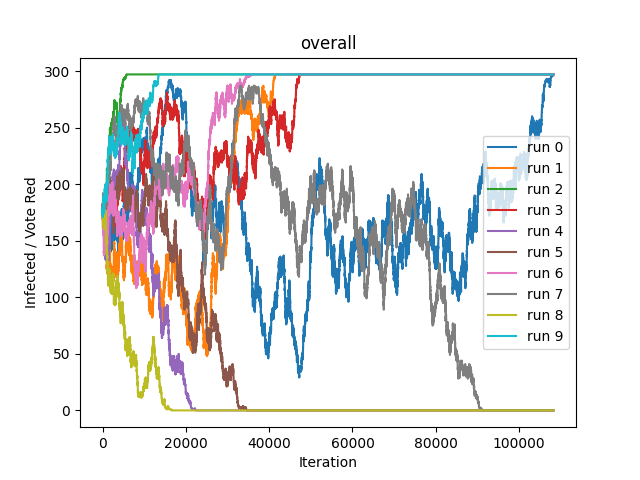

Number of runs: 10
Number of runs that converge to red: 6
Number of runs that converge to blue: 4


In [196]:
# plot_mean_and_bootstrapped_ci_over_time(input_data = status_count_over_time_list, name = ["Status over time"], x_label = "Iteration", y_label = "Infected / Voting Red", plot_bootstrap = True)
# plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(status_count_over_time_0), np.transpose(status_count_over_time_1)], name=["Status over time converges to blue", "Status over time converges to red"], x_label="Iteration", y_label="Infected / Vote Red")
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for x in status_count_over_time_list], name=["run {}".format(i) for i in range(len(status_count_over_time_list))], x_label="Iteration", y_label="Infected / Vote Red")
print("Number of runs: {}".format(num_runs))
print("Number of runs that converge to red: {}".format(len(status_count_over_time_1)))
print("Number of runs that converge to blue: {}".format(len(status_count_over_time_0)))

In [25]:
# Create random graph with configuration model
sequence = [d[1] for d in g.degree]
print(sum(sequence)/len(sequence))

g = nx.configuration_model(sequence)

actual_degrees = [d for v, d in g.degree()]

actual_degrees == sequence

# Should visualize somehow
# Could visualize with larger nodes for higher degree

14.464646464646465


True

<IPython.core.display.Javascript object>


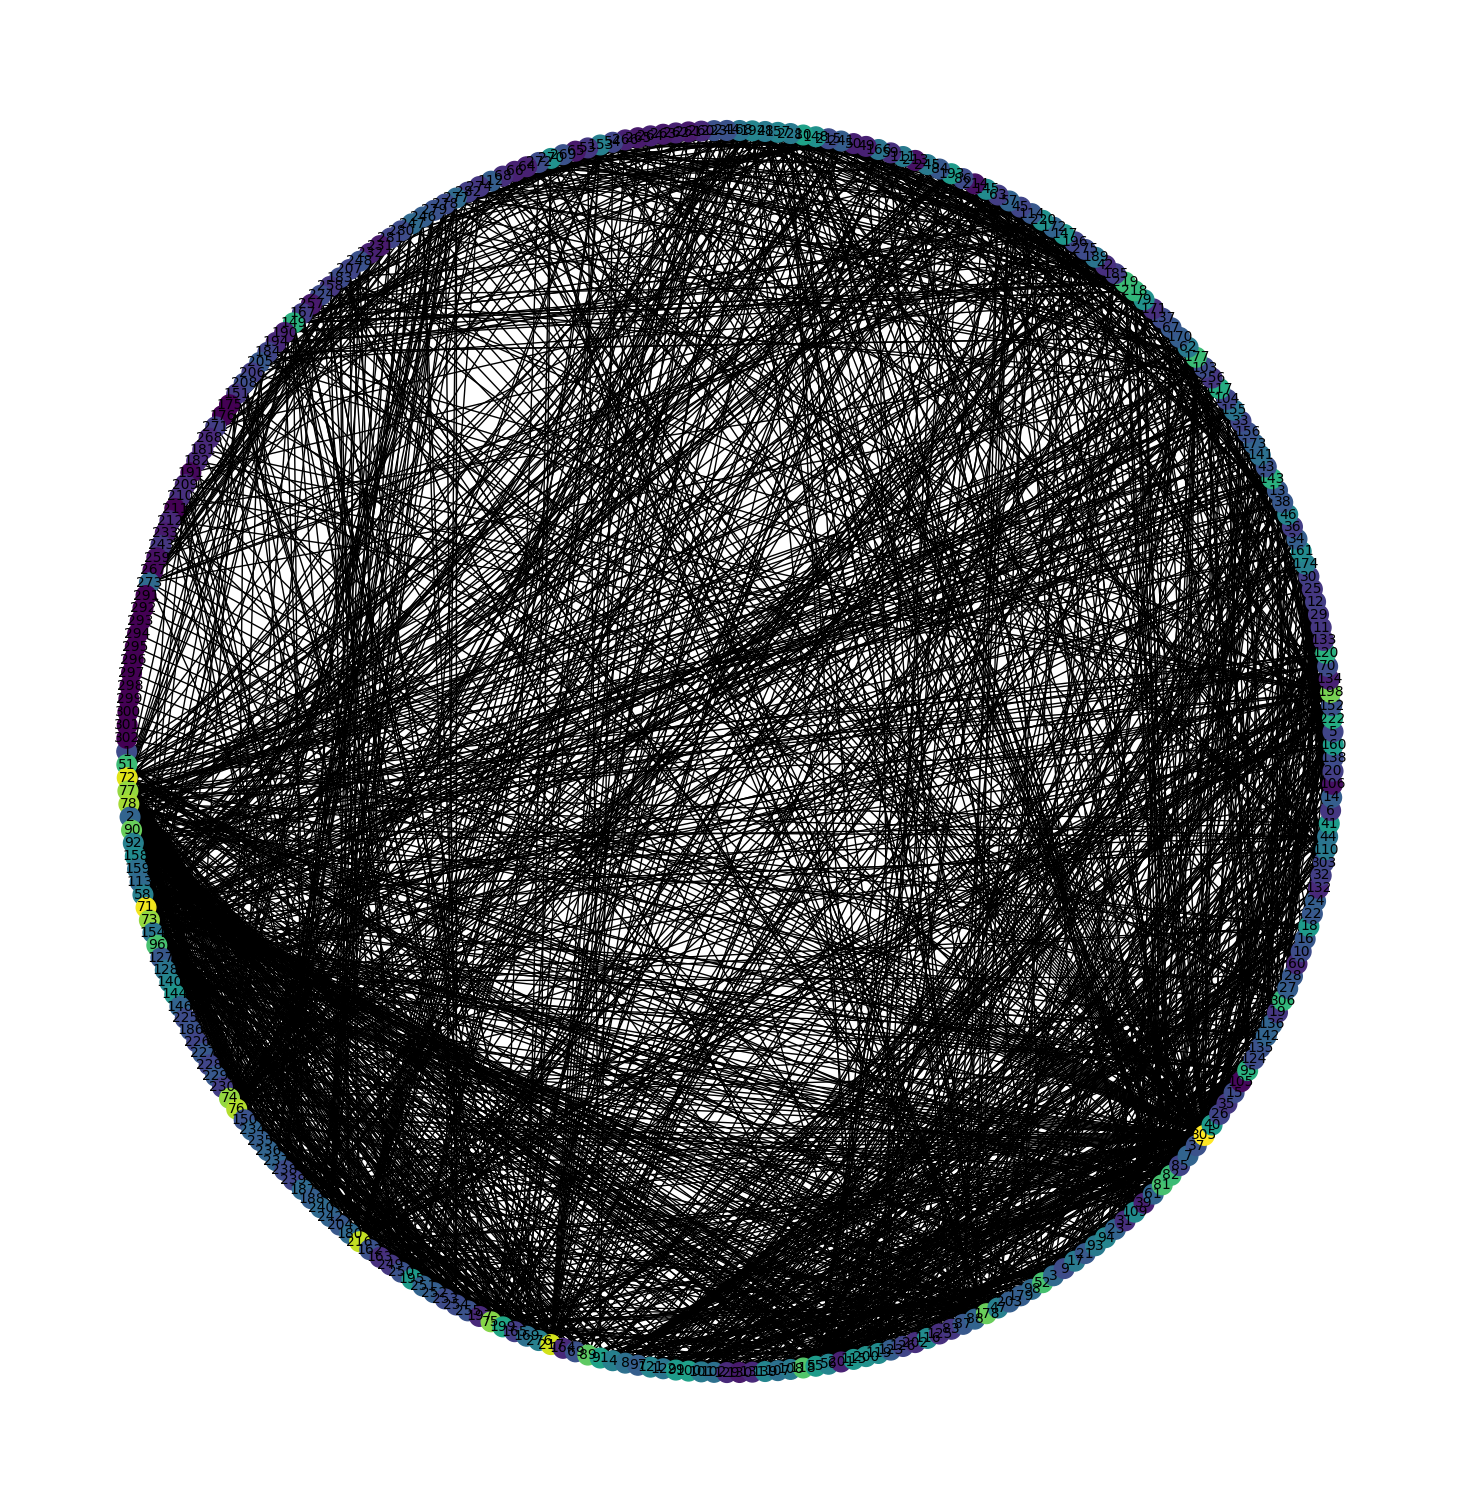

<IPython.core.display.Javascript object>


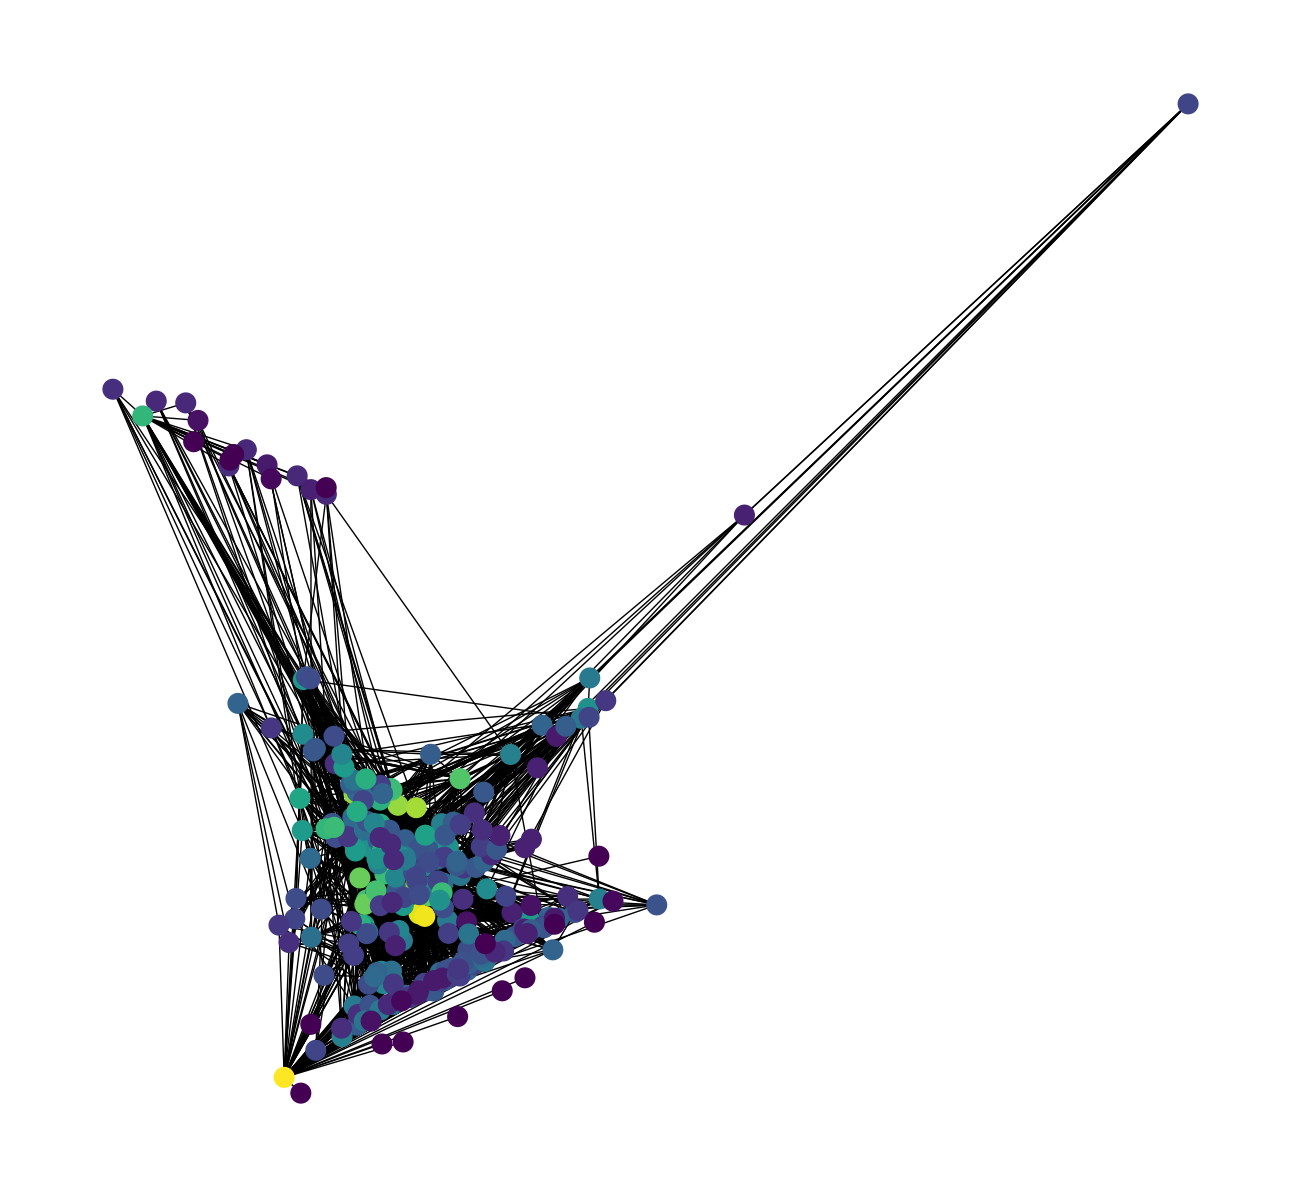

There are 150 duplicate edges: [(2, 86), (2, 117), (2, 117), (2, 189), (2, 123), (2, 2), (2, 2), (2, 12), (2, 55), (2, 217), (2, 58), (2, 28), (3, 6), (3, 49), (3, 100), (3, 13), (3, 147), (3, 181), (3, 117), (3, 43), (4, 60), (4, 260), (4, 176), (4, 84), (4, 70), (5, 144), (5, 187), (9, 85), (9, 105), (12, 12), (12, 12), (12, 117), (12, 117), (12, 117), (12, 28), (12, 28), (12, 28), (12, 77), (12, 23), (12, 13), (12, 64), (12, 178), (12, 178), (12, 129), (12, 151), (12, 113), (12, 261), (13, 238), (13, 219), (13, 100), (13, 188), (13, 195), (15, 156), (15, 165), (15, 129), (15, 80), (15, 153), (16, 153), (18, 117), (18, 56), (19, 50), (19, 117), (19, 117), (20, 81), (25, 143), (28, 117), (28, 164), (28, 43), (28, 279), (29, 189), (29, 153), (29, 153), (29, 181), (29, 224), (29, 117), (32, 164), (32, 131), (33, 151), (33, 245), (43, 63), (43, 112), (48, 143), (51, 129), (55, 130), (55, 117), (55, 117), (55, 176), (56, 171), (60, 60), (60, 80), (60, 117), (60, 129), (60, 197), (61, 84),

(14.464646464646465,
 'There are no indegrees for undirected graph',
 'There are no outdegrees for undirected graph',
 0.024433524433524433,
 'Is not defined for a multigraph or digraph',
 'Is not defined for a multigraph or digraph')

In [26]:
visualize_as_shell(g, '5', (5,5))
visualize_with_colors_for_degree(g, '6', (5,5))
describe_network(g)

In [30]:
# Create and run voter model again on it
num_runs = 10
num_iters_list = []
status_count_over_time_list = np.zeros((num_runs, 200000))
fraction_infected = 0.4

for i in range(num_runs):
    start_time = time.time()
    model = create_voter_model(g, fraction_infected)
    num_iters, status_count_over_time = calculate_voter_convergence(model)
    status_count_over_time = np.array([status_count_over_time[j] if j < len(status_count_over_time) else status_count_over_time[-1] for j in range(status_count_over_time_list.shape[1])])
    num_iters_list.append(num_iters)
    status_count_over_time_list[i] = status_count_over_time
    print('convergence of voter model', i, time.time()-start_time, num_iters)

status_count_over_time_list_truncated = np.zeros((num_runs, max(num_iters_list)))
for i in range(num_runs):
    status_count_over_time_list_truncated[i] = status_count_over_time_list[i][:max(num_iters_list)]
status_count_over_time_list = np.zeros((num_runs, max(num_iters_list)))
status_count_over_time_list = status_count_over_time_list_truncated
print(status_count_over_time_list)

convergence of voter model 0 6.199850797653198 20685
convergence of voter model 1 15.39078402519226 51192
convergence of voter model 2 5.17496657371521 16985
convergence of voter model 3 17.389008045196533 57904
convergence of voter model 4 3.6891841888427734 12246
convergence of voter model 5 5.120919704437256 16970
convergence of voter model 6 12.67243766784668 42049
convergence of voter model 7 1.9656965732574463 6494
convergence of voter model 8 11.796181440353394 39361
convergence of voter model 9 3.620124340057373 12230
[[118. 118. 117. ...   0.   0.   0.]
 [118. 118. 119. ...   0.   0.   0.]
 [118. 118. 118. ...   0.   0.   0.]
 ...
 [118. 118. 118. ...   0.   0.   0.]
 [118. 118. 118. ... 297. 297. 297.]
 [118. 118. 119. ...   0.   0.   0.]]


In [31]:
status_count_over_time_0 = []
status_count_over_time_1 = []
status_count_over_time_other = []
for i in range(len(status_count_over_time_list)):
    if status_count_over_time_list[i][-1] == len(g.nodes):
        status_count_over_time_1.append(status_count_over_time_list[i])
    elif status_count_over_time_list[i][-1] == 0:
        status_count_over_time_0.append(status_count_over_time_list[i])
    else:
        status_count_over_time_other.append(status_count_over_time_list[i])

status_count_over_time_0 = np.array(status_count_over_time_0)
status_count_over_time_1 = np.array(status_count_over_time_1)
print(status_count_over_time_other)

[]


<IPython.core.display.Javascript object>


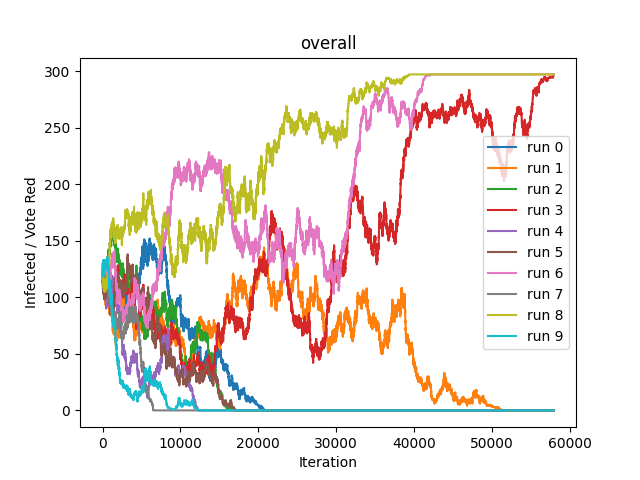

Number of runs: 10
Number of runs that converge to red: 3
Number of runs that converge to blue: 7


In [32]:
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for x in status_count_over_time_list], name=["run {}".format(i) for i in range(len(status_count_over_time_list))], x_label="Iteration", y_label="Infected / Vote Red")
print("Number of runs: {}".format(num_runs))
print("Number of runs that converge to red: {}".format(len(status_count_over_time_1)))
print("Number of runs that converge to blue: {}".format(len(status_count_over_time_0)))